# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

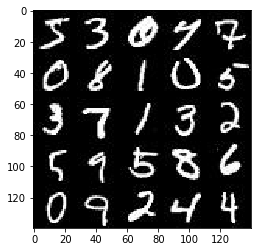

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

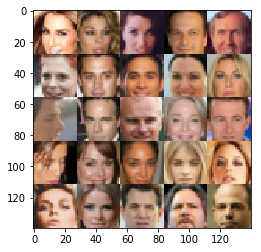

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.0-rc2
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z    = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr         = tf.placeholder(tf.float32, (), name='learning_rate')

    return input_real, input_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    drop_rate = 0.5/2.0
    size_mult = 64
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        x1 = tf.layers.conv2d(images, size_mult, 5, strides=2, 
                              kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        bn1 = tf.layers.batch_normalization(x1, training=True)
        relu1 = tf.maximum(alpha * bn1, bn1)
        relu1 = tf.layers.dropout(relu1, rate=drop_rate)
        
        x2 = tf.layers.conv2d(relu1, 2 * size_mult, 5, strides=2, 
                              kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        relu2 = tf.layers.dropout(relu2, rate=drop_rate)
        
        x3 = tf.layers.conv2d(relu2, 4 * size_mult, 5, strides=2, 
                              kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        relu3 = tf.layers.dropout(relu3, rate=drop_rate)
        
        x4 = tf.layers.conv2d(relu3, 8 * size_mult, 5, strides=2, 
                              kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        bn4 = tf.layers.batch_normalization(x4, training=True)
        relu4 = tf.maximum(alpha * bn4, bn4)
        
        flatten = tf.contrib.layers.flatten(relu4)
        logits = tf.layers.dense(flatten, 1, activation=None)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    size_mult = 64
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 2 * 2 * size_mult * 8)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, size_mult * 8))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, size_mult * 4, 5, strides=2, 
                                        kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, size_mult * 4, 5, strides=1, 
                                        kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        x4 = tf.layers.conv2d_transpose(x3, size_mult * 2, 5, strides=2, 
                                        kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        
        x5 = tf.layers.conv2d_transpose(x4, size_mult * 2, 5, strides=1, 
                                        kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        x5 = tf.layers.batch_normalization(x5, training=is_train)
        x5 = tf.maximum(alpha * x5, x5)
        
        logits = tf.layers.conv2d_transpose(x5, out_channel_dim, 5, strides=2, 
                                            kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    # Build the model
    g_model = generator(input_z, out_channel_dim)
    # g_model is the generator output

    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    smooth = 0.1
    
    # Calculate losses
    d_loss_real = tf.reduce_mean(
                      tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                              labels=tf.ones_like(d_logits_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
                      tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                              labels=tf.zeros_like(d_logits_real)))
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(
                 tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                         labels=tf.ones_like(d_logits_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get the trainable_variables, split into G and D parts
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    d_train_opt = tf.train.AdamOptimizer(learning_rate = learning_rate, beta1 = beta1).minimize(d_loss, var_list=d_vars)
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate = learning_rate, beta1 = beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    # Create our input placeholders
    input_real, input_z, lr = model_inputs(*data_shape[1:], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[-1])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 0
    n_images = 25
    show_output_step = 100
    print_loss_step = 20
    losses = []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                steps += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                batch_images *= 2
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, 
                                                     input_z: batch_z, 
                                                     lr: learning_rate})
                
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, 
                                                     lr: learning_rate})
                # Run g_train_opt twice
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, 
                                                     lr: learning_rate})
                
                if steps % print_loss_step == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % show_output_step == 0:
                    show_generator_output(sess, 25, input_z,  data_shape[-1], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.5010... Generator Loss: 4.6759
Epoch 1/2... Discriminator Loss: 1.1335... Generator Loss: 0.8942
Epoch 1/2... Discriminator Loss: 0.7284... Generator Loss: 1.4434
Epoch 1/2... Discriminator Loss: 0.9490... Generator Loss: 1.7143
Epoch 1/2... Discriminator Loss: 0.8721... Generator Loss: 3.3011


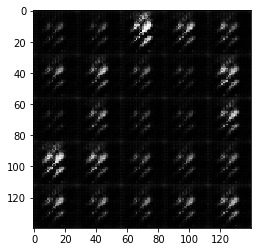

Epoch 1/2... Discriminator Loss: 0.8199... Generator Loss: 1.0612
Epoch 1/2... Discriminator Loss: 1.2669... Generator Loss: 0.9667
Epoch 1/2... Discriminator Loss: 1.2927... Generator Loss: 1.0112
Epoch 1/2... Discriminator Loss: 0.9849... Generator Loss: 1.0985
Epoch 1/2... Discriminator Loss: 1.8643... Generator Loss: 0.6841


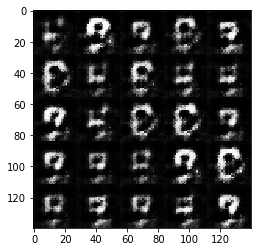

Epoch 1/2... Discriminator Loss: 1.0876... Generator Loss: 1.0806
Epoch 1/2... Discriminator Loss: 1.4366... Generator Loss: 0.7060
Epoch 1/2... Discriminator Loss: 1.2781... Generator Loss: 0.8372
Epoch 1/2... Discriminator Loss: 1.2688... Generator Loss: 0.8921
Epoch 1/2... Discriminator Loss: 1.4129... Generator Loss: 0.8457


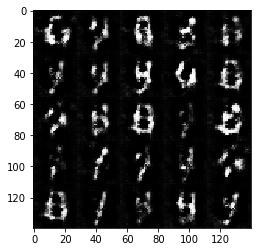

Epoch 1/2... Discriminator Loss: 1.1985... Generator Loss: 0.8720
Epoch 1/2... Discriminator Loss: 1.3070... Generator Loss: 0.7625
Epoch 1/2... Discriminator Loss: 1.6150... Generator Loss: 0.6538
Epoch 1/2... Discriminator Loss: 1.3422... Generator Loss: 0.7110
Epoch 1/2... Discriminator Loss: 1.3762... Generator Loss: 0.7378


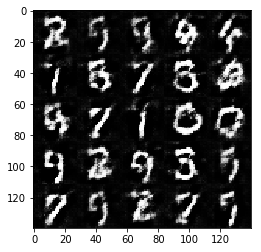

Epoch 1/2... Discriminator Loss: 1.2754... Generator Loss: 0.8853
Epoch 1/2... Discriminator Loss: 1.2954... Generator Loss: 0.7291
Epoch 1/2... Discriminator Loss: 1.5511... Generator Loss: 0.7348
Epoch 1/2... Discriminator Loss: 1.3814... Generator Loss: 0.9160
Epoch 1/2... Discriminator Loss: 1.4949... Generator Loss: 0.7475


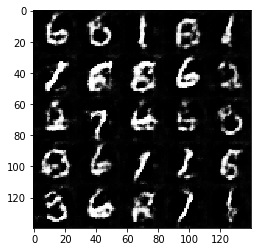

Epoch 1/2... Discriminator Loss: 1.3351... Generator Loss: 0.7571
Epoch 1/2... Discriminator Loss: 1.2905... Generator Loss: 0.7950
Epoch 1/2... Discriminator Loss: 1.3911... Generator Loss: 0.6641
Epoch 1/2... Discriminator Loss: 1.3490... Generator Loss: 0.7605
Epoch 1/2... Discriminator Loss: 1.3382... Generator Loss: 0.6964


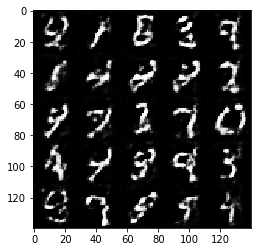

Epoch 1/2... Discriminator Loss: 1.3620... Generator Loss: 0.8004
Epoch 1/2... Discriminator Loss: 1.4486... Generator Loss: 1.0136
Epoch 1/2... Discriminator Loss: 1.4465... Generator Loss: 0.6189
Epoch 1/2... Discriminator Loss: 1.4875... Generator Loss: 0.7369
Epoch 1/2... Discriminator Loss: 1.3376... Generator Loss: 0.8454


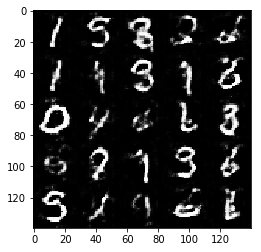

Epoch 1/2... Discriminator Loss: 1.4131... Generator Loss: 0.7889
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.7575
Epoch 1/2... Discriminator Loss: 1.3273... Generator Loss: 0.7531
Epoch 1/2... Discriminator Loss: 1.5073... Generator Loss: 0.6861
Epoch 1/2... Discriminator Loss: 1.4690... Generator Loss: 0.6135


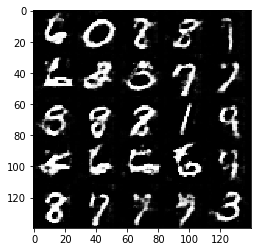

Epoch 1/2... Discriminator Loss: 1.4006... Generator Loss: 0.7394
Epoch 1/2... Discriminator Loss: 1.3207... Generator Loss: 1.0270
Epoch 1/2... Discriminator Loss: 1.4481... Generator Loss: 0.6901
Epoch 1/2... Discriminator Loss: 1.3272... Generator Loss: 0.7176
Epoch 1/2... Discriminator Loss: 1.4236... Generator Loss: 0.6651


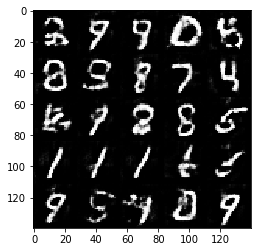

Epoch 1/2... Discriminator Loss: 1.4272... Generator Loss: 0.7184
Epoch 2/2... Discriminator Loss: 1.5283... Generator Loss: 0.4810
Epoch 2/2... Discriminator Loss: 1.4153... Generator Loss: 0.5774
Epoch 2/2... Discriminator Loss: 1.4188... Generator Loss: 0.7846
Epoch 2/2... Discriminator Loss: 1.3386... Generator Loss: 0.7732


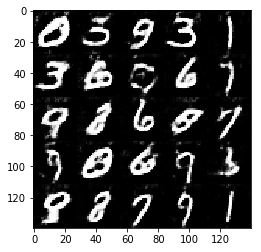

Epoch 2/2... Discriminator Loss: 1.3794... Generator Loss: 0.6848
Epoch 2/2... Discriminator Loss: 1.4003... Generator Loss: 0.6297
Epoch 2/2... Discriminator Loss: 1.3153... Generator Loss: 0.7036
Epoch 2/2... Discriminator Loss: 1.3372... Generator Loss: 0.8889
Epoch 2/2... Discriminator Loss: 1.5064... Generator Loss: 0.6365


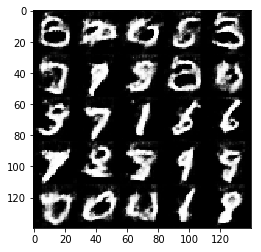

Epoch 2/2... Discriminator Loss: 1.2409... Generator Loss: 0.7683
Epoch 2/2... Discriminator Loss: 1.3109... Generator Loss: 0.6197
Epoch 2/2... Discriminator Loss: 1.7221... Generator Loss: 0.3331
Epoch 2/2... Discriminator Loss: 1.5317... Generator Loss: 0.5038
Epoch 2/2... Discriminator Loss: 1.4070... Generator Loss: 0.8098


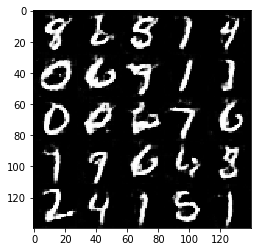

Epoch 2/2... Discriminator Loss: 1.2853... Generator Loss: 0.8644
Epoch 2/2... Discriminator Loss: 1.2955... Generator Loss: 0.9194
Epoch 2/2... Discriminator Loss: 1.3467... Generator Loss: 0.7165
Epoch 2/2... Discriminator Loss: 1.4250... Generator Loss: 0.5368
Epoch 2/2... Discriminator Loss: 1.3897... Generator Loss: 1.0319


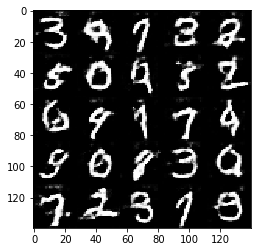

Epoch 2/2... Discriminator Loss: 1.4658... Generator Loss: 0.6576
Epoch 2/2... Discriminator Loss: 1.3914... Generator Loss: 0.7535
Epoch 2/2... Discriminator Loss: 1.3390... Generator Loss: 0.6427
Epoch 2/2... Discriminator Loss: 1.3671... Generator Loss: 0.5504
Epoch 2/2... Discriminator Loss: 1.2423... Generator Loss: 1.3459


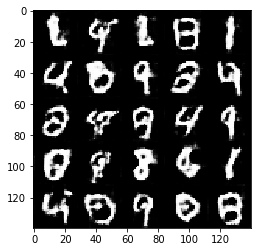

Epoch 2/2... Discriminator Loss: 1.4423... Generator Loss: 0.5903
Epoch 2/2... Discriminator Loss: 1.5416... Generator Loss: 0.4209
Epoch 2/2... Discriminator Loss: 1.4169... Generator Loss: 0.6272
Epoch 2/2... Discriminator Loss: 1.5219... Generator Loss: 0.5215
Epoch 2/2... Discriminator Loss: 1.2199... Generator Loss: 0.6397


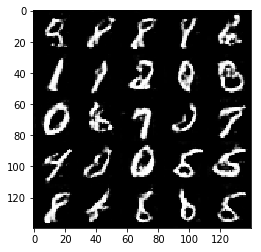

Epoch 2/2... Discriminator Loss: 1.5942... Generator Loss: 0.4156
Epoch 2/2... Discriminator Loss: 1.2460... Generator Loss: 0.8515
Epoch 2/2... Discriminator Loss: 1.1789... Generator Loss: 0.7860
Epoch 2/2... Discriminator Loss: 1.4941... Generator Loss: 0.4432
Epoch 2/2... Discriminator Loss: 1.4075... Generator Loss: 0.6335


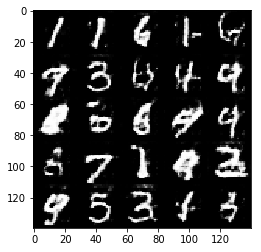

Epoch 2/2... Discriminator Loss: 1.2806... Generator Loss: 0.7432
Epoch 2/2... Discriminator Loss: 1.3215... Generator Loss: 0.8126
Epoch 2/2... Discriminator Loss: 1.0972... Generator Loss: 0.9258
Epoch 2/2... Discriminator Loss: 1.2319... Generator Loss: 0.7495
Epoch 2/2... Discriminator Loss: 1.5085... Generator Loss: 0.4383


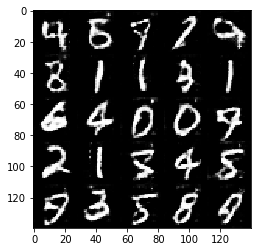

Epoch 2/2... Discriminator Loss: 1.1698... Generator Loss: 1.1488
Epoch 2/2... Discriminator Loss: 1.2533... Generator Loss: 0.7820
Epoch 2/2... Discriminator Loss: 0.9835... Generator Loss: 1.2664
Epoch 2/2... Discriminator Loss: 1.5125... Generator Loss: 0.5252
Epoch 2/2... Discriminator Loss: 1.4018... Generator Loss: 0.7341


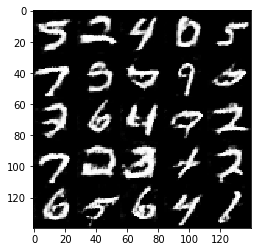

Epoch 2/2... Discriminator Loss: 1.3157... Generator Loss: 0.7007
Epoch 2/2... Discriminator Loss: 1.3351... Generator Loss: 0.6046
Epoch 2/2... Discriminator Loss: 1.3575... Generator Loss: 0.6126


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))

with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.0660... Generator Loss: 2.1690
Epoch 1/1... Discriminator Loss: 1.7772... Generator Loss: 1.1001
Epoch 1/1... Discriminator Loss: 1.4400... Generator Loss: 0.9594
Epoch 1/1... Discriminator Loss: 1.5678... Generator Loss: 0.6924
Epoch 1/1... Discriminator Loss: 1.9667... Generator Loss: 0.4466


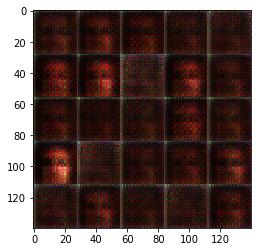

Epoch 1/1... Discriminator Loss: 1.6507... Generator Loss: 0.7808
Epoch 1/1... Discriminator Loss: 1.4156... Generator Loss: 0.8105
Epoch 1/1... Discriminator Loss: 1.3035... Generator Loss: 0.8823
Epoch 1/1... Discriminator Loss: 1.6554... Generator Loss: 0.7497
Epoch 1/1... Discriminator Loss: 1.5676... Generator Loss: 0.5892


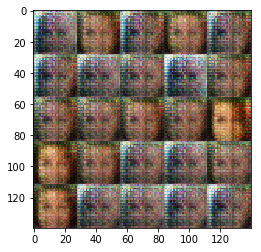

Epoch 1/1... Discriminator Loss: 1.6237... Generator Loss: 0.6019
Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 0.7167
Epoch 1/1... Discriminator Loss: 1.3220... Generator Loss: 0.7288
Epoch 1/1... Discriminator Loss: 1.2547... Generator Loss: 0.9694
Epoch 1/1... Discriminator Loss: 1.7112... Generator Loss: 0.7651


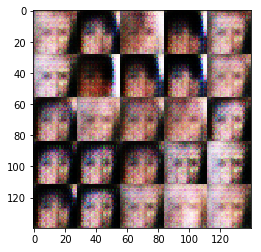

Epoch 1/1... Discriminator Loss: 1.5751... Generator Loss: 0.6486
Epoch 1/1... Discriminator Loss: 1.5043... Generator Loss: 0.7117
Epoch 1/1... Discriminator Loss: 1.4197... Generator Loss: 0.7464
Epoch 1/1... Discriminator Loss: 1.4277... Generator Loss: 0.7654
Epoch 1/1... Discriminator Loss: 1.4321... Generator Loss: 0.7355


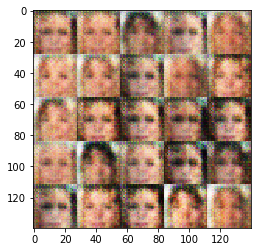

Epoch 1/1... Discriminator Loss: 1.4835... Generator Loss: 0.7146
Epoch 1/1... Discriminator Loss: 1.4819... Generator Loss: 0.7614
Epoch 1/1... Discriminator Loss: 1.4138... Generator Loss: 0.7592
Epoch 1/1... Discriminator Loss: 1.3990... Generator Loss: 0.7916
Epoch 1/1... Discriminator Loss: 1.3857... Generator Loss: 0.7810


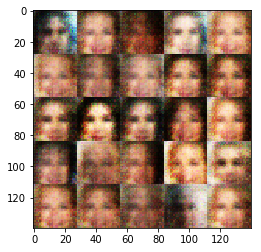

Epoch 1/1... Discriminator Loss: 1.4123... Generator Loss: 0.7696
Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 0.7461
Epoch 1/1... Discriminator Loss: 1.4226... Generator Loss: 0.7743
Epoch 1/1... Discriminator Loss: 1.4087... Generator Loss: 0.7713
Epoch 1/1... Discriminator Loss: 1.4002... Generator Loss: 0.7784


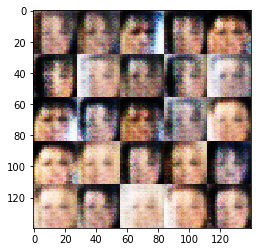

Epoch 1/1... Discriminator Loss: 1.4218... Generator Loss: 0.7604
Epoch 1/1... Discriminator Loss: 1.3560... Generator Loss: 0.8113
Epoch 1/1... Discriminator Loss: 1.3591... Generator Loss: 0.7898
Epoch 1/1... Discriminator Loss: 1.4068... Generator Loss: 0.7664
Epoch 1/1... Discriminator Loss: 1.4199... Generator Loss: 0.7711


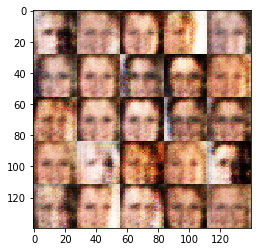

Epoch 1/1... Discriminator Loss: 1.4497... Generator Loss: 0.7601
Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.7601
Epoch 1/1... Discriminator Loss: 1.4054... Generator Loss: 0.7913
Epoch 1/1... Discriminator Loss: 1.4115... Generator Loss: 0.7833
Epoch 1/1... Discriminator Loss: 1.4355... Generator Loss: 0.7691


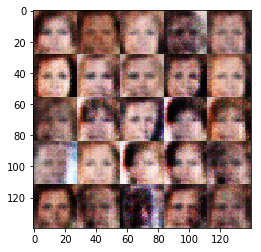

Epoch 1/1... Discriminator Loss: 1.3980... Generator Loss: 0.7842
Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 0.7879
Epoch 1/1... Discriminator Loss: 1.4002... Generator Loss: 0.7694
Epoch 1/1... Discriminator Loss: 1.4106... Generator Loss: 0.7762
Epoch 1/1... Discriminator Loss: 1.3936... Generator Loss: 0.7665


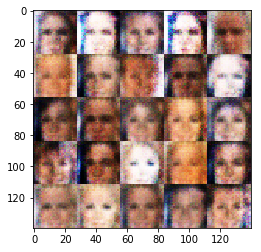

Epoch 1/1... Discriminator Loss: 1.4027... Generator Loss: 0.7696
Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 0.7837
Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 0.7856
Epoch 1/1... Discriminator Loss: 1.4129... Generator Loss: 0.7707
Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.7724


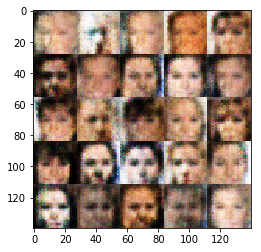

Epoch 1/1... Discriminator Loss: 1.4001... Generator Loss: 0.7752
Epoch 1/1... Discriminator Loss: 1.3825... Generator Loss: 0.7834
Epoch 1/1... Discriminator Loss: 1.4008... Generator Loss: 0.7739
Epoch 1/1... Discriminator Loss: 1.3947... Generator Loss: 0.7951
Epoch 1/1... Discriminator Loss: 1.3925... Generator Loss: 0.7845


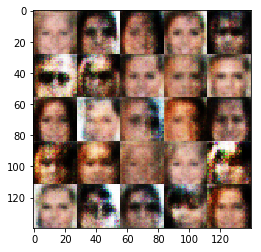

Epoch 1/1... Discriminator Loss: 1.4080... Generator Loss: 0.7810
Epoch 1/1... Discriminator Loss: 1.4056... Generator Loss: 0.7774
Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.7800
Epoch 1/1... Discriminator Loss: 1.3825... Generator Loss: 0.7735
Epoch 1/1... Discriminator Loss: 1.3857... Generator Loss: 0.7879


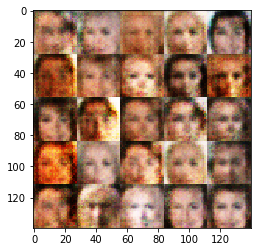

Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.7958
Epoch 1/1... Discriminator Loss: 1.4125... Generator Loss: 0.7705
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.7813
Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 0.7878
Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 0.7934


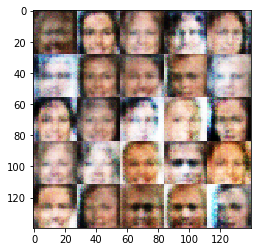

Epoch 1/1... Discriminator Loss: 1.3889... Generator Loss: 0.7913
Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.7764
Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.7730
Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.7850
Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 0.7994


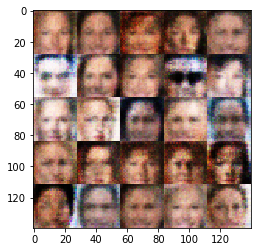

Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.7788
Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.7717
Epoch 1/1... Discriminator Loss: 1.3964... Generator Loss: 0.8023
Epoch 1/1... Discriminator Loss: 1.3911... Generator Loss: 0.7884
Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.7901


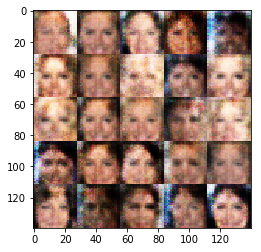

Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 0.7994
Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.7824
Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.7700
Epoch 1/1... Discriminator Loss: 1.3972... Generator Loss: 0.7693
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.7959


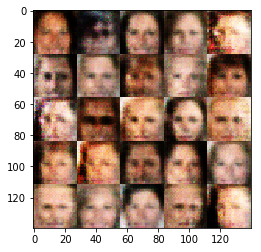

Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.7904
Epoch 1/1... Discriminator Loss: 1.3776... Generator Loss: 0.8078
Epoch 1/1... Discriminator Loss: 1.3932... Generator Loss: 0.7888
Epoch 1/1... Discriminator Loss: 1.3931... Generator Loss: 0.7947
Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.8006


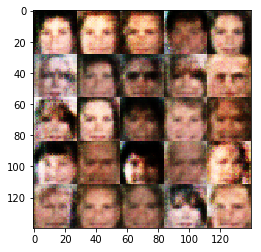

Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 0.7734
Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 0.8106
Epoch 1/1... Discriminator Loss: 1.3902... Generator Loss: 0.7939
Epoch 1/1... Discriminator Loss: 1.3928... Generator Loss: 0.7920
Epoch 1/1... Discriminator Loss: 1.3835... Generator Loss: 0.7877


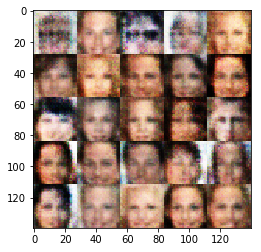

Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 0.7774
Epoch 1/1... Discriminator Loss: 1.3857... Generator Loss: 0.7637
Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 0.7880
Epoch 1/1... Discriminator Loss: 1.3886... Generator Loss: 0.8040
Epoch 1/1... Discriminator Loss: 1.3976... Generator Loss: 0.7924


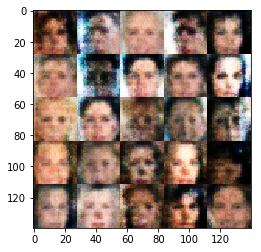

Epoch 1/1... Discriminator Loss: 1.3811... Generator Loss: 0.7917
Epoch 1/1... Discriminator Loss: 1.3812... Generator Loss: 0.8145
Epoch 1/1... Discriminator Loss: 1.3836... Generator Loss: 0.7930
Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.7939
Epoch 1/1... Discriminator Loss: 1.3923... Generator Loss: 0.7899


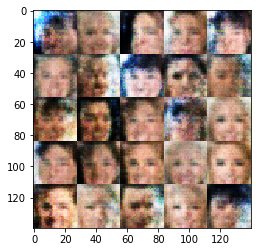

Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 0.8055
Epoch 1/1... Discriminator Loss: 1.3788... Generator Loss: 0.7965
Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 0.7846
Epoch 1/1... Discriminator Loss: 1.3802... Generator Loss: 0.7923
Epoch 1/1... Discriminator Loss: 1.3809... Generator Loss: 0.7937


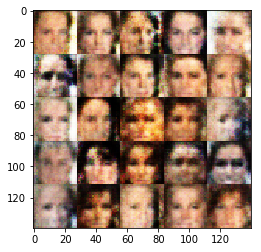

Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.7936
Epoch 1/1... Discriminator Loss: 1.3791... Generator Loss: 0.8007
Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 0.8068
Epoch 1/1... Discriminator Loss: 1.3833... Generator Loss: 0.7932
Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 0.7737


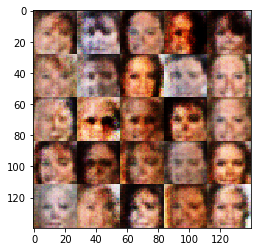

Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 0.8115
Epoch 1/1... Discriminator Loss: 1.3929... Generator Loss: 0.7874
Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.8018
Epoch 1/1... Discriminator Loss: 1.3800... Generator Loss: 0.7794
Epoch 1/1... Discriminator Loss: 1.3862... Generator Loss: 0.7944


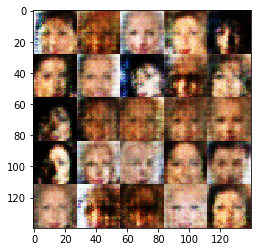

Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 0.7860
Epoch 1/1... Discriminator Loss: 1.3806... Generator Loss: 0.8058
Epoch 1/1... Discriminator Loss: 1.3827... Generator Loss: 0.7884
Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 0.8058
Epoch 1/1... Discriminator Loss: 1.3795... Generator Loss: 0.7915


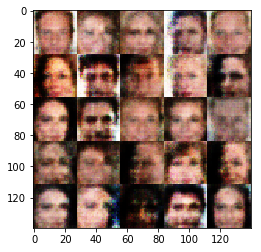

Epoch 1/1... Discriminator Loss: 1.3751... Generator Loss: 0.8103
Epoch 1/1... Discriminator Loss: 1.3948... Generator Loss: 0.7800
Epoch 1/1... Discriminator Loss: 1.3846... Generator Loss: 0.7924
Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.7898
Epoch 1/1... Discriminator Loss: 1.3765... Generator Loss: 0.7923


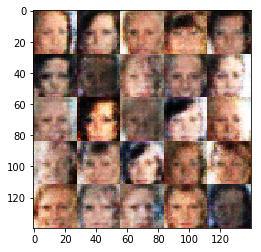

Epoch 1/1... Discriminator Loss: 1.3802... Generator Loss: 0.8023
Epoch 1/1... Discriminator Loss: 1.3841... Generator Loss: 0.8049
Epoch 1/1... Discriminator Loss: 1.3814... Generator Loss: 0.8178
Epoch 1/1... Discriminator Loss: 1.3838... Generator Loss: 0.8165
Epoch 1/1... Discriminator Loss: 1.3821... Generator Loss: 0.8060


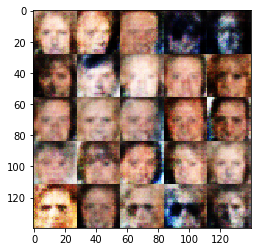

Epoch 1/1... Discriminator Loss: 1.3837... Generator Loss: 0.7874
Epoch 1/1... Discriminator Loss: 1.3870... Generator Loss: 0.7877
Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 0.8143
Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 0.7772
Epoch 1/1... Discriminator Loss: 1.3805... Generator Loss: 0.7870


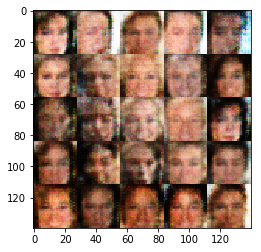

Epoch 1/1... Discriminator Loss: 1.3752... Generator Loss: 0.7998
Epoch 1/1... Discriminator Loss: 1.3814... Generator Loss: 0.7976
Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 0.7627
Epoch 1/1... Discriminator Loss: 1.3805... Generator Loss: 0.8042
Epoch 1/1... Discriminator Loss: 1.3842... Generator Loss: 0.7800


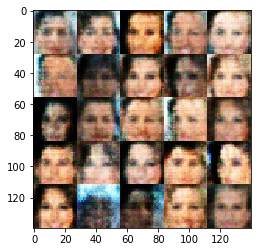

Epoch 1/1... Discriminator Loss: 1.3836... Generator Loss: 0.7818
Epoch 1/1... Discriminator Loss: 1.3814... Generator Loss: 0.7973
Epoch 1/1... Discriminator Loss: 1.3853... Generator Loss: 0.7669
Epoch 1/1... Discriminator Loss: 1.3803... Generator Loss: 0.8008
Epoch 1/1... Discriminator Loss: 1.3800... Generator Loss: 0.7963


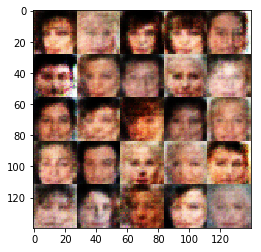

Epoch 1/1... Discriminator Loss: 1.3770... Generator Loss: 0.7854
Epoch 1/1... Discriminator Loss: 1.3816... Generator Loss: 0.8081
Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 0.8012
Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 0.7845
Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.7573


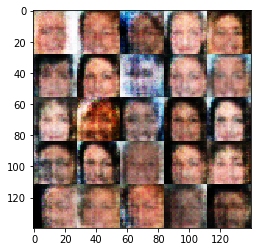

Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 0.7679
Epoch 1/1... Discriminator Loss: 1.3827... Generator Loss: 0.7983
Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 0.7889
Epoch 1/1... Discriminator Loss: 1.3779... Generator Loss: 0.8039
Epoch 1/1... Discriminator Loss: 1.3827... Generator Loss: 0.7940


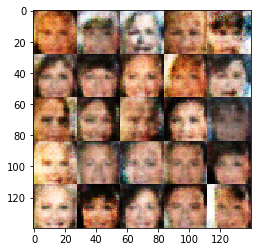

Epoch 1/1... Discriminator Loss: 1.3802... Generator Loss: 0.8121
Epoch 1/1... Discriminator Loss: 1.3802... Generator Loss: 0.8025
Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 0.7937


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.